In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.quantum_info import Operator

from penalty import *
from topology import *

key = random.PRNGKey(0)

# Helper functions

In [96]:
@jit
def box_angles(a):
    """Bring angles within range (-pi, pi)"""
    aright = a + jnp.pi
    aright = aright % (2*jnp.pi)
    a_center = aright - jnp.pi
    return a_center

def cz_count(angles, epsilon=1e-2):
    """Count how many angles in cp gates a close to identity, CNOT and generic."""
    count = 0
    for a in angles:
        if jnp.abs(a)<epsilon:
            count += 0
        elif jnp.abs(a-jnp.pi)<epsilon or jnp.abs(a+jnp.pi)<epsilon:
            count += 1
        else:
            count +=2
            
    return count

def TLB(n):
    return int((4**n-3*n-1)/4 + 1)


def random_pair(key, num_qubits):
    key, subkey = random.split(key)
    i, j = random.randint(key, shape=(2,), minval=0, maxval=num_qubits)
    if i==j:
        return random_pair(key, num_qubits)
    else:
        return i,j

def random_placements(key, num_qubits, num_cz):
    *keys, _ = random.split(key, num=num_cz+1)
    return [random_pair(key, num_qubits) for key in keys ]        

def random_special_unitary(key, num_qubits, num_cz):
    placements = {'free': random_placements(key, num_qubits, num_cz)}
    a =  Ansatz(num_qubits, 'cz', placements)
    angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
    return a.unitary(angles), placements

def plot_histories(learndict, n):
    plt.plot(learndict['loss'][n], label='loss')
    plt.plot(learndict['disc'][n], label='disc')
    plt.plot(learndict['reg'][n], label='reg')
    plt.legend()
    plt.yscale('log')
    
def get_cp_angles(learndict, n):
    angles = learndict['angles'][n][-1] 
    cp_angles = angles * a.control_angles
    cp_angles = cp_angles[cp_angles!=0]
    return cp_angles
    
def plot_angles(cp_angles, penalty_options):
    asweep = jnp.linspace(-jnp.pi-0.5, jnp.pi+0.5, num=100)

    plt.plot(asweep, cp_penalty_linear(asweep, penalty_options['height'], penalty_options['threshold']))
    plt.plot(cp_angles, cp_penalty_linear(cp_angles, penalty_options['height'], penalty_options['threshold']), 'bo')
    
def learn_cz_count(a, u_target, penalty_options, attempts=10, verbose=True, target_disc=1e-3, **kwargs):
    
    angles_annals = []
    loss_annals = []
    disc_annals = []
    reg_annals = []
    cz_counts = []
    cz_counts_successfull = []
    
    for i in range(attempts):
        key = random.PRNGKey(i)
        initial_angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
        initial_angles = initial_angles*(1-a.control_angles)

        angles_history, loss_history = a.learn(u_target, regularization_options=penalty_options, 
                                               init_angles=initial_angles, **kwargs)

        angles_history = vmap(box_angles)(jnp.array(angles_history))
        loss_history = jnp.array(loss_history)

        disc_history =  vmap(jit(lambda angs: disc(a.unitary(angs), u_target)))(angles_history)
        reg_history = vmap(jit(lambda angs: penalty(angs, penalty_options)))(angles_history)

        angles_annals.append(angles_history)
        loss_annals.append(loss_history)
        disc_annals.append(disc_history)
        reg_annals.append(reg_history)

        fid = disc_history[-1]<target_disc
        count = cz_count(angles_history[-1]*a.control_angles)

        cz_counts.append(count)
        if fid:
            cz_counts_successfull.append(count)
        
        if verbose:
            print('iteration: {}, disc below {}: {}, cz count: {}'.format(i, target_disc, fid, count))

    if cz_counts_successfull:
        best_count = min(cz_counts_successfull)
        percentage = cz_counts_successfull.count(best_count)/len(cz_counts_successfull)*100
    else:
        best_count = -1
        percentage = 100
    print('\n')
    print('best count: {}, percentage: {} %'.format(best_count, percentage)) 
    
    return {'angles': angles_annals,
           'loss': loss_annals,
           'disc': disc_annals,
           'reg': reg_annals,
           'cz': cz_counts,
           'cz+': cz_counts_successfull}


# Two-qubit experiments

In [406]:
# u_target = unitary_group.rvs(4, random_state=2)
u_target = random_special_unitary(random.PRNGKey(1), 2, 3)
a = Ansatz(2, 'cp', fill_layers(sequ_layer(2), 50))

# Options do not work for all layer depths!
penalty_options = {'function': 'linear', 
                   'height':2,
                   'regularization': 1e-3,
                   'threshold': 0.01,
                   'angles': a.control_angles}

learndict = learn_cz_count(a, u_target, penalty_options=penalty_options, attempts=10)

iteration: 0, fidelity below 1e-3: True, cz count: 3 

iteration: 1, fidelity below 1e-3: True, cz count: 4 

iteration: 2, fidelity below 1e-3: True, cz count: 3 

iteration: 3, fidelity below 1e-3: True, cz count: 5 

iteration: 4, fidelity below 1e-3: True, cz count: 3 

iteration: 5, fidelity below 1e-3: True, cz count: 5 



KeyboardInterrupt: 

# 3-qubit

First let us try to find good values of hyperparameters to learn random unitaries on 3 qubits.

In [46]:
n_q = 3

u_target = unitary_group.rvs(2**n_q, random_state=1)
layer  = sequ_layer(n_q)
a = Ansatz(n_q, 'cp', fill_layers(layer, TLB(n_q)*len(layer)))

# Options do not work for all layer depths!
penalty_options = {'function': 'linear', 
                   'height':2,
                   'regularization': 3*1e-3,
                   'threshold': 0.01,
                   'angles': a.control_angles}

learndict = learn_cz_count(a, u_target, penalty_options=penalty_options, attempts=10, num_iterations=5000)

iteration: 0, disc below 0.001: True, cz count: 16
iteration: 1, disc below 0.001: True, cz count: 15
iteration: 2, disc below 0.001: True, cz count: 13
iteration: 3, disc below 0.001: True, cz count: 16
iteration: 4, disc below 0.001: False, cz count: 18
iteration: 5, disc below 0.001: True, cz count: 17
iteration: 6, disc below 0.001: True, cz count: 15
iteration: 7, disc below 0.001: True, cz count: 18
iteration: 8, disc below 0.001: False, cz count: 13
iteration: 9, disc below 0.001: True, cz count: 16


best count: 13, percentage: 12.5 %


Now let's see if the same parameters can be used to learn special 3-qubit unitaries.

In [99]:
depth = 8
u_target, target_placements = random_special_unitary(random.PRNGKey(0), n_q, depth)

penalty_options = {'function': 'linear', 
                   'height':1.5,
                   'regularization': 4*1e-3,
                   'threshold': 0.01,
                   'angles': a.control_angles}

learndict = learn_cz_count(a, u_target, penalty_options=penalty_options, attempts=10, num_iterations=5000)

iteration: 0, disc below 0.001: True, cz count: 14
iteration: 1, disc below 0.001: True, cz count: 16
iteration: 2, disc below 0.001: True, cz count: 16
iteration: 3, disc below 0.001: True, cz count: 17
iteration: 4, disc below 0.001: True, cz count: 13


KeyboardInterrupt: 

In [106]:
u_target, target_placements = random_special_unitary(random.PRNGKey(1), n_q, depth)
a_tailored = Ansatz(n_q, 'cz', target_placements)

la = []
for i in range(10):
    initial_angles = random.uniform(random.PRNGKey(i), shape=(a_tailored.num_angles, ), minval=0, maxval=2*jnp.pi)
    _, lh = a_tailored.learn(u_target, init_angles=initial_angles)
    la.append(lh)

8


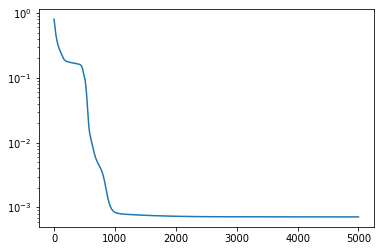

In [117]:
plt.plot(la[3])
plt.yscale('log')

In [ ]:
plot_histories(learndict, -1)

In [ ]:
plot_angles(get_cp_angles(learndict, -1), penalty_options)

# 3-qubit Toffoli

In [88]:
qc_toff3 = QuantumCircuit(3)
qc_toff3.ccx(0,1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

## Plain topology

In [49]:
u_target = u_toff3
a = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

penalty_options = {'function': 'linear', 
                   'height':2,
                   'regularization': 1e-3,
                   'threshold': 0.1,
                   'angles': a.control_angles}

key, subkey = random.split(key)
initial_angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
initial_angles = initial_angles*(1-a.control_angles)

angles_history, loss_history = a.learn(u_target, regularization_options=penalty_options)

angles_history = vmap(box_angles)(jnp.array(angles_history))
loss_history = jnp.array(loss_history)

disc_history =  vmap(jit(lambda angs: disc(a.unitary(angs), u_target)))(angles_history)
reg_history = vmap(jit(lambda angs: penalty(angs, penalty_options)))(angles_history)

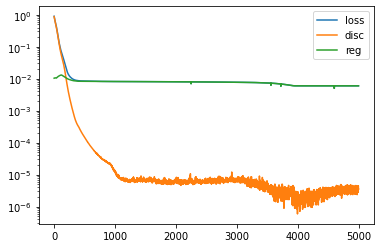

In [50]:
plt.plot(loss_history, label='loss')
plt.plot(disc_history, label='disc')
plt.plot(reg_history, label='reg')
plt.legend()
plt.yscale('log')

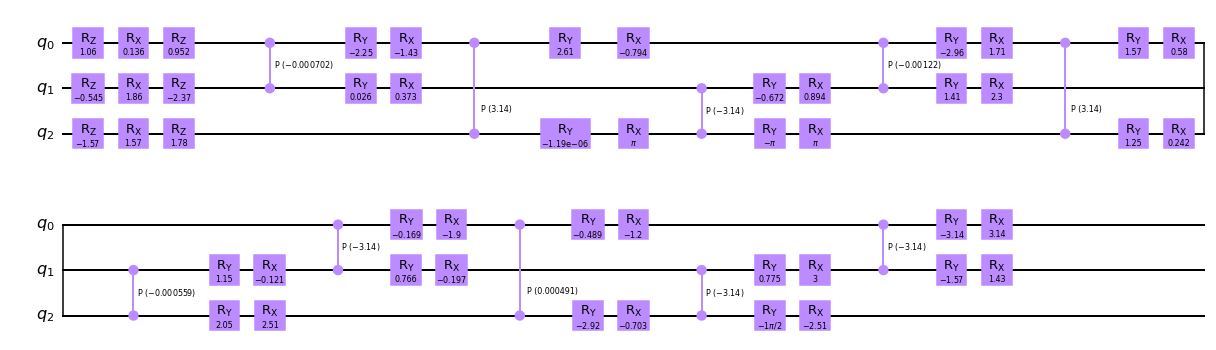

In [51]:
cz_count(angles_history[-1]*a.control_angles)
a.circuit(angles_history[-1]).draw(output='mpl')

## Restricted topology

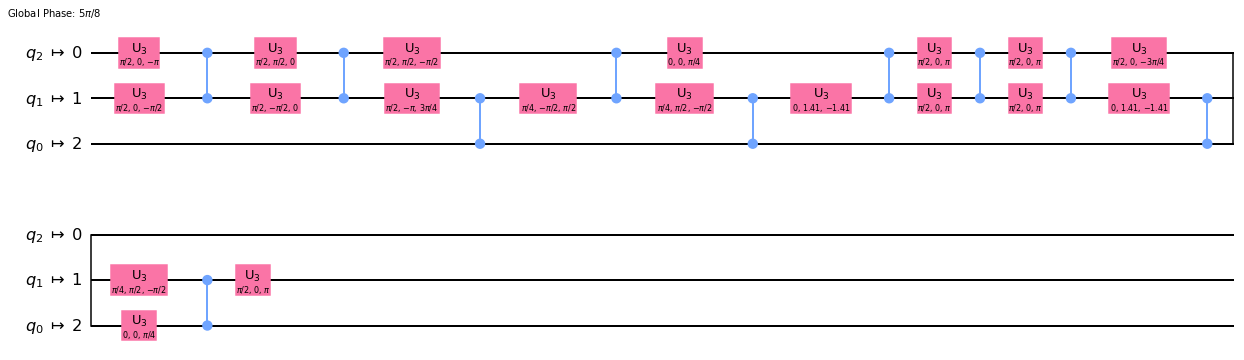

In [100]:
qc_toff3_trans = transpile(qc_toff3, basis_gates=['cz', 'u3'], coupling_map = [[0,1], [1,0], [1,2], [2,1]], optimization_level=3)
qc_toff3_trans.draw(output='mpl')

In [97]:
u_toff3 = Operator(qc_toff3.reverse_bits()).data
u_toff3_trans = Operator(qc_toff3_trans.reverse_bits()).data

In [170]:
u_target = u_toff3

restricted_layer = [[0, 1], [1, 2]]
a = Ansatz(3, 'cp', fill_layers(restricted_layer, 40))

penalty_options = {'function': 'linear', 
                   'height':2,
                   'regularization': 1e-4,
                   'threshold': 0.1,
                   'angles': a.control_angles}

target_disc = 1e-3
for n in range(1):
    key = random.PRNGKey(n)
    initial_angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
    initial_angles = initial_angles*(1-a.control_angles)

    angles_history, loss_history = a.learn(u_target, regularization_options=penalty_options, 
                                           target_disc=target_disc, num_iterations=25000,
                                           init_angles=initial_angles)

    angles_history = vmap(box_angles)(jnp.array(angles_history))
    loss_history = jnp.array(loss_history)
    
    disc_history =  vmap(jit(lambda angs: disc(a.unitary(angs), u_target)))(angles_history)
    reg_history = vmap(jit(lambda angs: penalty(angs, penalty_options)))(angles_history)
    
    if disc_history[-1] < target_disc:
        print('fidelity achieved')
        print('cz count is {}'.format(cz_count(angles_history[-1]*a.control_angles)))
    else:
        print('fidelity not achieved')
        print('cz count is {}'.format(cz_count(angles_history[-1]*a.control_angles)))

fidelity achieved
cz count is 10


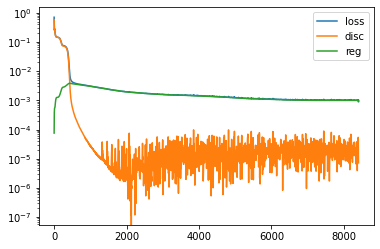

In [171]:
plt.plot(loss_history, label='loss')
plt.plot(disc_history, label='disc')
plt.plot(reg_history, label='reg')
plt.legend()
plt.yscale('log')

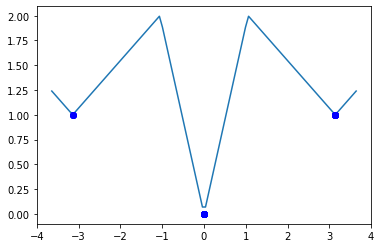

In [172]:
asweep = jnp.linspace(-jnp.pi-0.5, jnp.pi+0.5, num=100)

cp_angles = angles_history[-1]*a.control_angles
cp_angles = cp_angles[cp_angles!=0]

plt.plot(asweep, cp_penalty_linear(asweep, penalty_options['height'], penalty_options['threshold']))
plt.plot(cp_angles, cp_penalty_linear(cp_angles, penalty_options['height'], penalty_options['threshold']), 'bo')

# 4 Toffoli

In [109]:
qc_toff4 = QuantumCircuit(4)
qc_toff4.mct([0,1,2], 3)
u_toff4 = Operator(qc_toff4.reverse_bits()).data

In [232]:
%%time

u_target = u_toff4

a = Ansatz(4, 'cp', fill_layers(sequ_layer(4), 50))

penalty_options = {'function': 'linear', 
                   'height':2,
                   'regularization': 4.85*1e-5,
                   'threshold': 0.01,
                   'angles': a.control_angles}

target_disc = 1e-3
for n in range(1):
    key = random.PRNGKey(n)
    initial_angles = random.uniform(key, shape=(a.num_angles, ), minval=0, maxval=2*jnp.pi)
    initial_angles = initial_angles*(1-a.control_angles)

    angles_history, loss_history = a.learn(u_target, regularization_options=penalty_options, 
                                           num_iterations=50000,
                                           init_angles=initial_angles)

    angles_history = vmap(box_angles)(jnp.array(angles_history))
    loss_history = jnp.array(loss_history)
    
    disc_history =  vmap(jit(lambda angs: disc(a.unitary(angs), u_target)))(angles_history)
    reg_history = vmap(jit(lambda angs: penalty(angs, penalty_options)))(angles_history)
    
    if disc_history[-1] < target_disc:
        print('fidelity achieved')
        print('cz count is {}'.format(cz_count(angles_history[-1]*a.control_angles)))
    else:
        print('fidelity not achieved')
        print('cz count is {}'.format(cz_count(angles_history[-1]*a.control_angles)))

fidelity achieved
cz count is 18
CPU times: user 1min 43s, sys: 3.09 s, total: 1min 46s
Wall time: 1min 19s


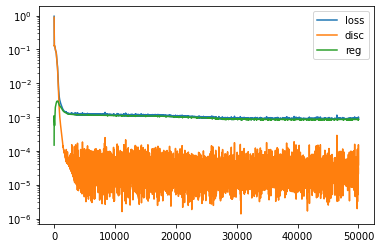

In [233]:
plt.plot(loss_history, label='loss')
plt.plot(disc_history, label='disc')
plt.plot(reg_history, label='reg')
plt.legend()
plt.yscale('log')

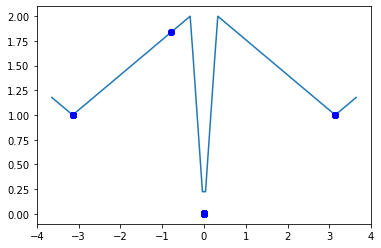

In [234]:
asweep = jnp.linspace(-jnp.pi-0.5, jnp.pi+0.5, num=100)

cp_angles = angles_history[-1]*a.control_angles
cp_angles = cp_angles[cp_angles!=0]

plt.plot(asweep, cp_penalty_linear(asweep, penalty_options['height'], penalty_options['threshold']))
plt.plot(cp_angles, cp_penalty_linear(cp_angles, penalty_options['height'], penalty_options['threshold']), 'bo')